In [51]:
import pandas as pd
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from ipyleaflet import *
import json
import requests 
from IPython.display import clear_output
from ipywidgets import HTML

In [2]:
onlyfiles = [f for f in listdir("spreadsheets/") if isfile(join("spreadsheets/", f))]
onlyfiles

['Drinking Water Watch Dataset.xlsx',
 'Public Potable Water Systems FINAL 06-22-2018_0.csv',
 'uw_self-cert_submittals.xlsx']

In [3]:
allfiles = {}
for a in onlyfiles:
    if ".xlsx" in a:
        allfiles[a.split(' ', 1)[0]] = pd.ExcelFile("spreadsheets/" + a)
    if ".csv" in a:
        print(a)
        allfiles[a.split(' ', 1)[0]] = pd.read_csv("spreadsheets/" + a, encoding='ISO-8859-1')

Public Potable Water Systems FINAL 06-22-2018_0.csv


In [4]:
alldata = {}
for key, b in allfiles.items():
    if type(b) is pd.ExcelFile:
        alldata[key] = {}
        for a in b.sheet_names:
            alldata[key][a] = b.parse(a)
    if type(b) is pd.DataFrame:
        alldata[key] = {}
        alldata[key][key] = b
print(alldata.keys())

dict_keys(['Drinking', 'Public', 'uw_self-cert_submittals.xlsx'])


In [5]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [6]:
a = alldata['Drinking']["Table3_AllWellLocations"]
b = alldata["Public"]['Public']
print("Drinking data - well locations (found online ) has shape: " + str(a.shape))
print("Public Potable water (Greg gave us) has shape " + str(b.shape))


Drinking data - well locations (found online ) has shape: (29632, 10)
Public Potable water (Greg gave us) has shape (7898, 31)


In [7]:
c = a.merge(b, left_on='WATER_SYSTEM_NO', right_on='Water System No ')

In [8]:
c.keys()

Index(['REG_AGENCY', 'WATER_SYSTEM_NO', 'PWS_NAME', 'SYSTEM_ACTIVITY_STATUS', 'FACILITY_NAME', 'WSF_Activity', 'WSF_ID', 'WSF_Type', 'LATITUDE_MEASURE', 'LONGITUDE_MEASURE', 'Water System No ', 'Water System Name', 'Principal County Served', 'Federal Water System Type -CODE', 'Federal Water System Type ', 'State Water System Type -CODE', 'State Water System Type', 'Water System Status -CODE', 'Water System Status', 'Owner Type -CODE', 'Owner Type', 'Primary Water Source Type -CODE', 'Primary Water Source Type', 'Residential Population', 'Non Transient Population', 'Transient Population', 'Total Population', 'Number of Service Connections Agricultural', 'Number of COMBINED Service Connections (CB)', 'Number of Commercial (CM) Service Connections', 'Numer of Institutional Service Conections', 'Number of Residential Service Connections', 'Total Number of Service Connections', 'Fee Code', 'Fee Code Description', 'Date of Sanitary Survey visit (SNSV Visit Date)', 'CITY',
       'Treatment P

In [9]:
c.head(100)

REG_AGENCY WATER_SYSTEM_NO                                 PWS_NAME SYSTEM_ACTIVITY_STATUS                             FACILITY_NAME WSF_Activity WSF_ID WSF_Type  LATITUDE_MEASURE  LONGITUDE_MEASURE Water System No                         Water System Name Principal County Served Federal Water System Type -CODE   Federal Water System Type  State Water System Type -CODE      State Water System Type Water System Status -CODE Water System Status Owner Type -CODE          Owner Type Primary Water Source Type -CODE      Primary Water Source Type  Residential Population  Non Transient Population  Transient Population  Total Population  Number of Service Connections Agricultural  Number of COMBINED Service Connections (CB)  Number of Commercial (CM) Service Connections  Numer of Institutional Service Conections  Number of Residential Service Connections  Total Number of Service Connections Fee Code                        Fee Code Description  \
0   DISTRICT 01 - KLAMATH       CA0800526                      REDWOOD PARK C.S.D.                      A  WELL 01                             XCLD            A    001       WL         41.575194        -124.066962        CA0800526                      REDWOOD PARK C.S.D.               DEL NORTE                               C                    Community                          C                       Community                         A              ACTIVE                L               Local                             GW                     Groundwater                   200.0                       NaN                   NaN             200.0                                         NaN                                         44.0                                            NaN                                        NaN                                        NaN                                 44.0    SC                                Small Community   
1   DISTRICT 01 - KLAMATH       CA0800526                      REDWOOD PARK C.S.D.                      A  WELL 02                             XCLD            A    002       WL         41.575217        -124.066908        CA0800526                      REDWOOD PARK C.S.D.               DEL NORTE                               C                    Community                          C                       Community                         A              ACTIVE                L               Local                             GW                     Groundwater                   200.0                       NaN                   NaN             200.0                                         NaN                                         44.0                                            NaN                                        NaN                                        NaN                                 44.0    SC                                Small Community   
2   DISTRICT 01 - KLAMATH       CA0800526                      REDWOOD PARK C.S.D.                      A        WELL 03 - OUTSIDE - REPRESENTATIVE            A    003       WL         41.575224        -124.066872        CA0800526                      REDWOOD PARK C.S.D.               DEL NORTE                               C                    Community                          C                       Community                         A              ACTIVE                L               Local                             GW                     Groundwater                   200.0                       NaN                   NaN             200.0                                         NaN                                         44.0                                            NaN                                        NaN                                        NaN                                 44.0    SC                                Small Community   
3   DISTRICT 01 - KLAMATH       CA0800532                          BIG ROCK C.S.D.                      A          SMITH RIVER INFILTRATION GALLERY

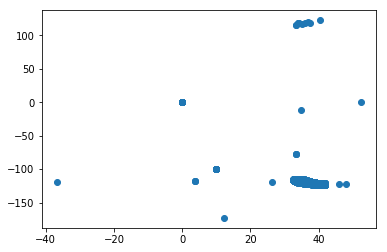

In [305]:
plt.scatter(c["LATITUDE_MEASURE"], c["LONGITUDE_MEASURE"])
plt.show()

In [306]:
removed_null_na = c.dropna(subset=['LATITUDE_MEASURE', 'LONGITUDE_MEASURE'])
removed_null_na = removed_null_na[(removed_null_na['LATITUDE_MEASURE'] != 0) & (removed_null_na['LONGITUDE_MEASURE'] != 0)]
print( str(len(removed_null_na)) + " out of " + str(len(c)) + " rows have complete and nonzero latitude and longitude" )

19890 out of 23277 rows have complete and nonzero latitude and longitude


In [307]:
primary_merged = removed_null_na.copy(deep = True)


In [308]:
abandoned = primary_merged[primary_merged['FACILITY_NAME'].str.contains("ABANDONED|DESTROYED")]
print(str(len(abandoned)) + " out of " + str(len(primary_merged)) + " wells are abandoned or destroyed")
primary_merged = primary_merged[~(primary_merged['FACILITY_NAME'].str.contains("ABANDONED|DESTROYED"))]
print("updated # rows:" + str(len(primary_merged)))

3293 out of 19890 wells are abandoned or destroyed
updated # rows:16597


In [309]:
fill_dict = {'Residential Population': 0, 'Non Transient Population': 0, 
                                       'Transient Population': 0, 'Total Population': 0, 'Number of Service Connections Agricultural': 0,
                                       'Number of COMBINED Service Connections (CB)': 0, 'Number of Commercial (CM) Service Connections': 0,
                                       'Numer of Institutional Service Conections': 0, 'Number of Residential Service Connections': 0,
                                       'Total Number of Service Connections': 0 }
primary_merged = primary_merged.fillna(value = fill_dict)
primary_merged.head(20)

REG_AGENCY WATER_SYSTEM_NO                      PWS_NAME SYSTEM_ACTIVITY_STATUS                             FACILITY_NAME WSF_Activity WSF_ID WSF_Type  LATITUDE_MEASURE  LONGITUDE_MEASURE Water System No              Water System Name Principal County Served Federal Water System Type -CODE Federal Water System Type  State Water System Type -CODE  State Water System Type Water System Status -CODE Water System Status Owner Type -CODE Owner Type Primary Water Source Type -CODE Primary Water Source Type  Residential Population  Non Transient Population  Transient Population  Total Population  Number of Service Connections Agricultural  Number of COMBINED Service Connections (CB)  Number of Commercial (CM) Service Connections  Numer of Institutional Service Conections  Number of Residential Service Connections  Total Number of Service Connections Fee Code                        Fee Code Description Date of Sanitary Survey visit (SNSV Visit Date)           CITY  \
0   DISTRICT 01 - KLAMATH       CA0800526           REDWOOD PARK C.S.D.                      A  WELL 01                             XCLD            A    001       WL         41.575194        -124.066962        CA0800526           REDWOOD PARK C.S.D.               DEL NORTE                               C                  Community                          C                   Community                         A              ACTIVE                L      Local                             GW                Groundwater                   200.0                       0.0                   0.0             200.0                                         0.0                                         44.0                                            0.0                                        0.0                                        0.0                                 44.0    SC                                Small Community                                        5/7/2018        KLAMATH   
1   DISTRICT 01 - KLAMATH       CA0800526           REDWOOD PARK C.S.D.                      A  WELL 02                             XCLD            A    002       WL         41.575217        -124.066908        CA0800526           REDWOOD PARK C.S.D.               DEL NORTE                               C                  Community                          C                   Community                         A              ACTIVE                L      Local                             GW                Groundwater                   200.0                       0.0                   0.0             200.0                                         0.0                                         44.0                                            0.0                                        0.0                                        0.0                                 44.0    SC                                Small Community                                        5/7/2018        KLAMATH   
2   DISTRICT 01 - KLAMATH       CA0800526           REDWOOD PARK C.S.D.                      A        WELL 03 - OUTSIDE - REPRESENTATIVE            A    003       WL         41.575224        -124.066872        CA0800526           REDWOOD PARK C.S.D.               DEL NORTE                               C                  Community                          C                   Community                         A              ACTIVE                L      Local                             GW                Groundwater                   200.0                       0.0                   0.0             200.0                                         0.0                                         44.0                                            0.0                                        0.0                                        0.0                                 44.0    SC                                Small Community                                        5/7/2018        KLAMATH   
3   DISTRICT 01 - KLAMATH       CA0800532               BIG ROC

In [310]:
info_widgets = HTML(
    placeholder="Here's some useful info"
)

def summarize(df, county_name):
    mapping = {}
    df0 = df.groupby(['WATER_SYSTEM_NO']).mean()
    mapping['Total Residential Population Served: '] = df0['Residential Population'].sum()
    mapping['Total Non Transient Population Served: '] = df0['Non Transient Population'].sum()
    mapping['Total Transient Population Served: '] = df0['Transient Population'].sum()
    mapping['Total Population Served: '] = df0['Total Population'].sum()
    mapping['Average Number of Service Connections: '] = df0['Total Number of Service Connections'].mean().astype(int)
    return pd.DataFrame.from_dict(mapping, orient='index', columns= ["County Name : " + county_name])

In [321]:
m = Map(center=(37.871593, -122.272743), zoom=5)
with open('ca_boundary.json', 'r') as f:
    data = json.load(f)
geo_json = GeoJSON(data=data, style = {'color': 'red', 'opacity':0.5, 'weight':1.1, 'dashArray':'5', 'fillOpacity':0})
m.add_layer(geo_json)
m.add_control(FullScreenControl())
prev_marker_layer = None
m.add_layer(popup)

def handle_click(**kwargs):
    if kwargs.get('type') == 'click':
        click_lat_long = kwargs.get('coordinates')
        request_query = "https://geo.fcc.gov/api/census/area?lat=" + \
            str(click_lat_long[0]) + "&lon=" + str(click_lat_long[1]) +"&format=json"
        response_json = json.loads(requests.get(request_query).text) 
        if 'results' in response_json.keys():
            if response_json['results'] != []:
                state_name = response_json['results'][0]['state_name']
                county_name = response_json['results'][0]['county_name']
                end = "<p> Sorry, but I have no data about states other than California </p>" if state_name != 'California' else ""
                info_widgets.value = "<p>The latitude, longitude for your click: <b>" + str(tuple(click_lat_long)) + "</b><br>" + \
                "This corresponds to the county: <b>" + county_name + "</b> in " + str(state_name) + "</p>"  + end

                if state_name == 'California':
                    global prev_marker_layer
                    if prev_marker_layer != None:
                        m.remove_layer(prev_marker_layer)
                    county_name = county_name.upper()
                    want_columns = ['WATER_SYSTEM_NO', 'Water System Name','FACILITY_NAME','LATITUDE_MEASURE', 
                                    'LONGITUDE_MEASURE', 'Primary Water Source Type', 'REG_AGENCY',
                                   'Water System Status', 'Residential Population', 'Non Transient Population', 
                                   'Transient Population', 'Total Population', 'Number of Service Connections Agricultural',
                                    'Number of COMBINED Service Connections (CB)', 'Number of Commercial (CM) Service Connections',
                                    'Numer of Institutional Service Conections', 'Number of Residential Service Connections','Total Number of Service Connections']
                    found_rows = primary_merged[primary_merged['Principal County Served'] == county_name][want_columns]
                    if len(found_rows) > 0:
                        summary = summarize(found_rows, county_name)
                        info_widgets.value += "<p> I found <b>"+ str(len(found_rows))+ "</b> water facilities that belong to <b>" + str(len(summary))+ "</b> water systems</p>"
                        info_widgets.value += "<p> Here's some summary statistics for the water systems: </p>" + \
                                              summary.to_html()
                        info_widgets.value += "<p> Try clicking on the markers for more info about each water facility </p>"
                        all_markers = []
                        for i in range(len(found_rows)):
                            found_row = found_rows.iloc[i]
                            source_lat, source_long = found_row['LATITUDE_MEASURE'], found_row['LONGITUDE_MEASURE']
                            well_info = HTML()
                            found_row = pd.DataFrame(found_row)
                            found_row.style.set_properties(**{'text-align': 'right'})
                            well_info.value = found_row.to_html(header = False)
                            all_markers.append(Marker(location= [float(source_lat), float(source_long)], popup = well_info))
                        new_marker_layer = MarkerCluster(markers = all_markers)
                        prev_marker_layer = new_marker_layer
                        m.add_layer(new_marker_layer)
                            
m.on_interaction(handle_click)

In [322]:
display(info_widgets)
display(m)

HTML(value='<p>The latitude, longitude for your click: <b>(38.70989303926043, -121.95480118031058)</b><br>This…

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …